## SPI-M report

In [100]:
import pandas as pd
import seaborn as sns
import statsmodels as sm
import statsmodels.api as sma
from patsy import dmatrices
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import math
sns.set()

In [101]:
param_names = [
    "R_0",
    "hazard_rate_scale",
    "contact_tracing_success_prob",
    "contact_trace_delay_par",
    "infection_detect_prob",
    "global_contact_reduction",
    "2_step_tracing",
    "prob_has_trace_app",
    "test_delay_mean"
    ]
col_names = param_names + [str(i) for i in range(90)]
data_in = pd.read_excel("Data/simulation_results.xlsx", index_col = 0)
data = data_in.copy()

In [102]:
col_names_dict = {}
for i in range(len(col_names)):
    col_names_dict.update({i : col_names[i]})

In [103]:
data = data.rename(columns = col_names_dict)
data

,R_0,hazard_rate_scale,contact_tracing_success_prob,contact_trace_delay_par,infection_detect_prob,global_contact_reduction,2_step_tracing,prob_has_trace_app,test_delay_mean,0,...,80,81,82,83,84,85,86,87,88,89
0,2.8,0.816518,0.770141,2.495783,0.221253,0.482141,False,0.518484,1.227684,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.6,0.829253,0.753791,1.761410,0.577870,0.660483,True,0.408466,1.748835,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.8,0.816518,0.815418,2.310191,0.548626,0.619248,True,0.350897,1.817683,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.8,0.816518,0.871417,1.771790,0.309807,0.525622,False,0.081058,1.603589,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,0.803782,0.883309,2.170938,0.391792,0.544564,True,0.304183,1.912434,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.6,0.829253,0.905301,1.530946,0.560323,0.488210,False,0.466132,1.252075,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,2.6,0.829253,0.854972,2.418402,0.697184,0.571527,False,0.616044,1.549330,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,2.6,0.829253,0.866499,1.977446,0.509624,0.574874,True,0.163383,1.211282,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9998,2.6,0.829253,0.832270,2.391325,0.204550,0.550785,False,0.172722,1.714965,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


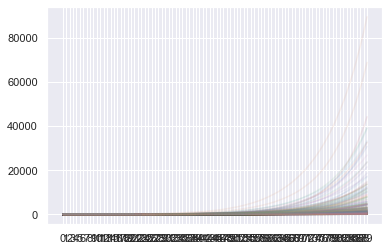

In [104]:
data_subset = data.loc[(data["2_step_tracing"] == False)]
for _ in range(data_subset.shape[0]):
    plt.plot(data_subset.iloc[_][9:], alpha = 0.1)

C:\Users\mfyles\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Log2 counts (all epidemics)')

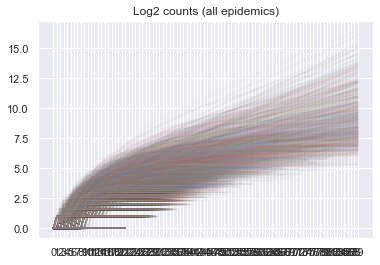

In [105]:
logged_data = data.apply(lambda x: np.log2(x))
for _ in range(logged_data.shape[0]):
    plt.plot(logged_data.iloc[_][9:], alpha = 0.05)
plt.title("Log2 counts (all epidemics)")

In [106]:
epidemics_not_extinct = data.dropna()

Text(0.5, 1.0, 'Log2 counts (non-extinct epidemcis)')

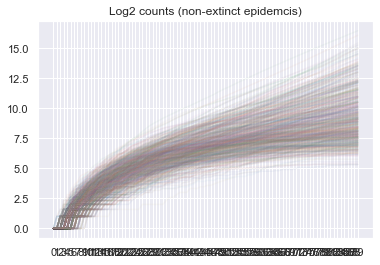

In [107]:
logged_data = epidemics_not_extinct.apply(lambda x: np.log2(x))
for _ in range(logged_data.shape[0]):
    plt.plot(logged_data.iloc[_][9:], alpha = 0.05)
plt.title("Log2 counts (non-extinct epidemcis)")

In [108]:
epidemics_extinct = data[data.isnull().any(axis=1)]

Text(0.5, 1.0, 'Log2 counts (extinct epidemics)')

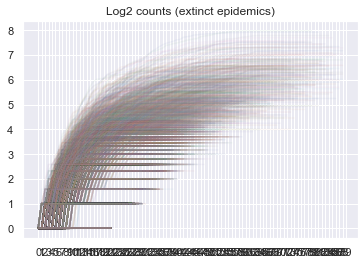

In [109]:
logged_data = epidemics_extinct.apply(lambda x: np.log2(x))
for _ in range(logged_data.shape[0]):
    plt.plot(logged_data.iloc[_][9:], alpha = 0.05)
plt.title("Log2 counts (extinct epidemics)")

## Sensitivity Analysis

We have several metrics to examine.
* Whether the epidemic became extinct
* If the epidemic did not become extinct, we report it's growth rate
* If the epidemic did because extinct, we report it's extinction time and final size

When we say extinct, we refer to a functionally extinct epidemic, all cases are either recovered or isolated (with the assumed 100% effectiveness).

In [126]:
epidemics_not_extinct = epidemics_not_extinct.assign(times_doubled = lambda x: np.log2(x["59"]))
epidemics_not_extinct = epidemics_not_extinct.assign(av_doubling_time = lambda x: 59/np.log2(x["59"]))
epidemics_not_extinct["two_step_tracing_int"] =  epidemics_not_extinct["2_step_tracing"].astype(int)

Text(0.5, 1.0, 'Pairwise relationships of parameters (non extinct epidemics)')

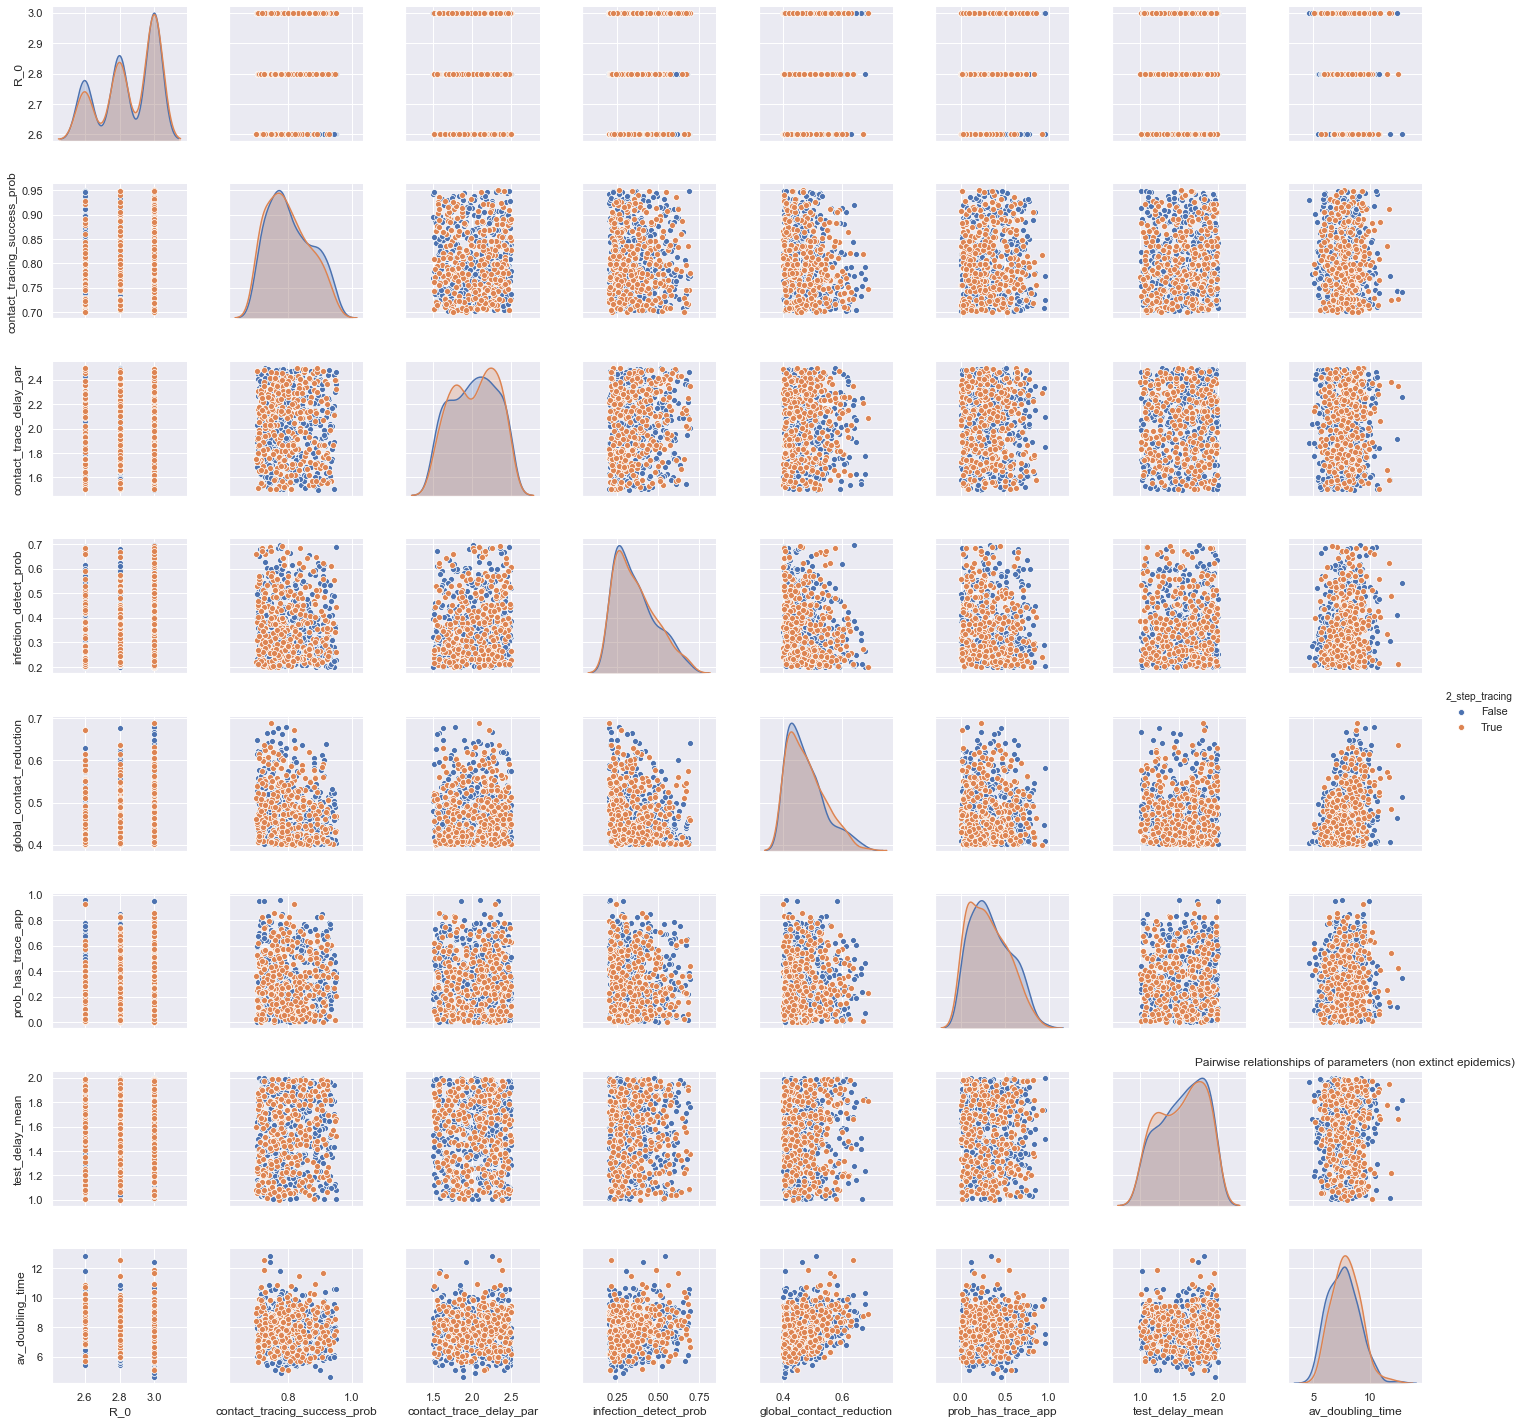

In [113]:
var_names = [
    "R_0",
    "contact_tracing_success_prob",
    "contact_trace_delay_par",
    "infection_detect_prob",
    "global_contact_reduction",
    "2_step_tracing",
    "prob_has_trace_app",
    "test_delay_mean",
    "av_doubling_time"
    ]

plot_names = [
    "R_0",
    "contact_tracing_success_prob",
    "contact_trace_delay_par",
    "infection_detect_prob",
    "global_contact_reduction",
    "prob_has_trace_app",
    "test_delay_mean",
    "av_doubling_time"
    ]
#two_step_not_extinct = epidemics_not_extinct[epidemics_not_extinct["2_step_tracing"] == True]
pair = sns.pairplot(epidemics_not_extinct[var_names], vars = plot_names, hue = "2_step_tracing")
plt.title("Pairwise relationships of parameters (non extinct epidemics)")

The probability that a single case goes extinct within 60 days is sensitive to the infection detection probability, R_0. The doubling time is also sensitive to the global reduction in contacts and infection detection probabilities.

There is a relationship between the range of doubling times and the $R_0$ of the epidemic. This must be due to the fact that an epidemic with an R_0 of 2.6 goes extinct due to the contact tracing process unless it doubles sufficiently quickly.

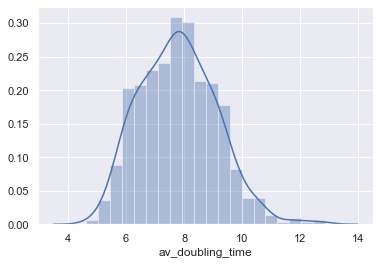

In [114]:
sns.distplot(epidemics_not_extinct["av_doubling_time"])

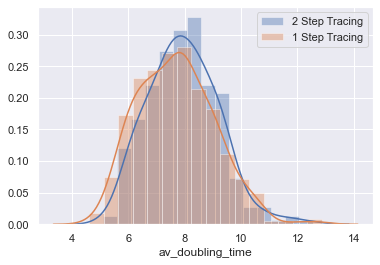

In [115]:
sns.distplot(epidemics_not_extinct.loc[epidemics_not_extinct["2_step_tracing"] == True]["av_doubling_time"])
sns.distplot(epidemics_not_extinct.loc[epidemics_not_extinct["2_step_tracing"] == False]["av_doubling_time"])
plt.legend(("2 Step Tracing", "1 Step Tracing"))

Text(0.5, 1.0, 'Average Doubling Time (Epidemics that did go extinct)')

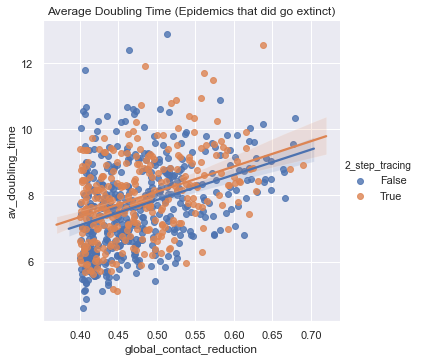

In [116]:
sns.lmplot("global_contact_reduction", "av_doubling_time", data = epidemics_not_extinct, hue = "2_step_tracing")
plt.title("Average Doubling Time (Epidemics that did go extinct)")

In [117]:
epidemics_not_extinct.assign(times_doubled = lambda x: np.log2(x["79"]))

,R_0,hazard_rate_scale,contact_tracing_success_prob,contact_trace_delay_par,infection_detect_prob,global_contact_reduction,2_step_tracing,prob_has_trace_app,test_delay_mean,0,...,83,84,85,86,87,88,89,times_doubled,av_doubling_time,2_step_tracing_int
26,3.0,0.803782,0.770148,2.143057,0.364974,0.416331,False,0.348271,1.670159,1,...,6019.0,6546.0,7081.0,7650.0,8308.0,8995.0,9794.0,12.103943,5.897511,0
32,3.0,0.803782,0.870855,2.261214,0.279233,0.433818,True,0.508886,1.158872,1,...,728.0,772.0,813.0,863.0,905.0,939.0,981.0,9.211888,7.412059,1
45,2.8,0.816518,0.780759,1.537127,0.305277,0.472102,False,0.230366,1.280193,1,...,1275.0,1352.0,1427.0,1503.0,1590.0,1674.0,1769.0,10.020980,7.417468,0
63,3.0,0.803782,0.766749,2.449753,0.304595,0.541606,False,0.429645,1.908134,1,...,338.0,351.0,361.0,373.0,392.0,415.0,431.0,8.108524,8.240372,0
73,2.8,0.816518,0.891250,1.715433,0.223965,0.525480,True,0.684370,1.744529,1,...,191.0,192.0,193.0,197.0,199.0,199.0,203.0,7.507795,8.161776,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,3.0,0.803782,0.814895,1.864827,0.223465,0.563403,True,0.751326,1.978618,1,...,93.0,93.0,93.0,93.0,93.0,93.0,93.0,6.539159,9.531773,1
9973,3.0,0.803782,0.846240,2.233053,0.451052,0.491336,True,0.094264,1.905828,1,...,523.0,552.0,567.0,594.0,605.0,626.0,649.0,8.813781,7.711358,1
9988,3.0,0.803782,0.775994,2.218982,0.401418,0.407738,False,0.767591,1.195600,1,...,1179.0,1221.0,1254.0,1288.0,1327.0,1369.0,1413.0,10.070121,6.254942,0
9992,3.0,0.803782,0.814381,2.357915,0.359939,0.422426,False,0.358997,1.179820,1,...,8766.0,9362.0,10104.0,10812.0,11666.0,12523.0,13491.0,12.685187,5.594064,0


In [127]:
epidemics_not_extinct["two_step_tracing_int"]

26      0
32      1
45      0
63      0
73      1
       ..
9960    1
9973    1
9988    0
9992    0
9999    0
Name: two_step_tracing_int, Length: 737, dtype: int32

                            OLS Regression Results                            
Dep. Variable:       av_doubling_time   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     42.76
Date:                Sun, 26 Apr 2020   Prob (F-statistic):           3.46e-56
Time:                        16:23:35   Log-Likelihood:                -1105.8
No. Observations:                 737   AIC:                             2230.
Df Residuals:                     728   BIC:                             2271.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

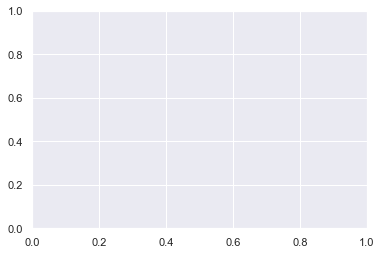

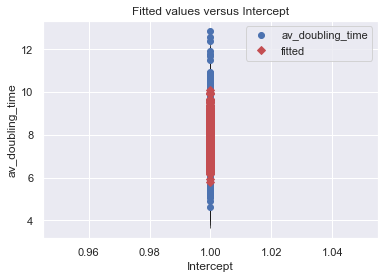

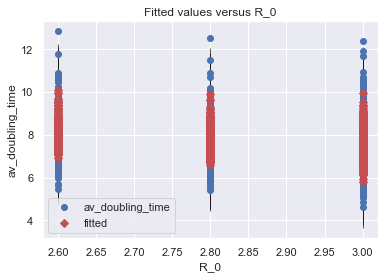

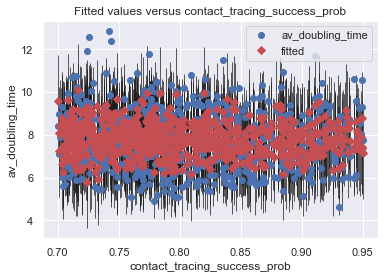

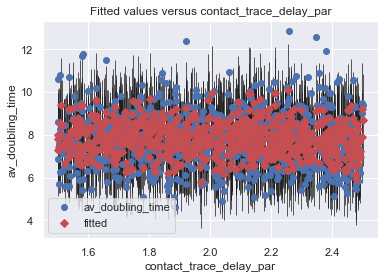

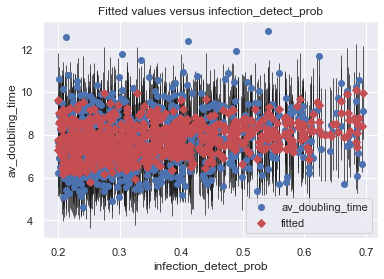

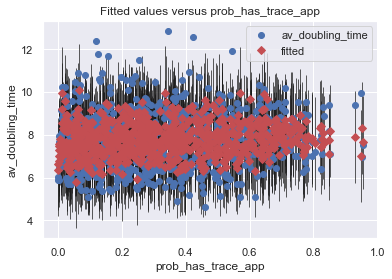

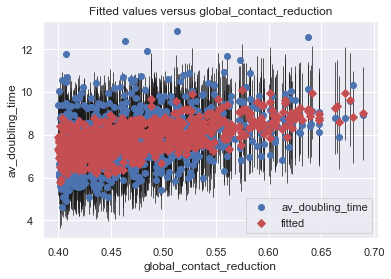

In [128]:
y, X = dmatrices('av_doubling_time ~ R_0 + contact_tracing_success_prob + contact_trace_delay_par + infection_detect_prob + prob_has_trace_app + global_contact_reduction + test_delay_mean + two_step_tracing_int', 
                 data = epidemics_not_extinct, return_type='dataframe')
model = sma.OLS(y, X)
res = model.fit()
print(res.summary())
fig, ax = plt.subplots()
for i in range(7):

    fig = sm.graphics.regressionplots.plot_fit(res, i)

## Epidemic Doubling Times - all epidemics

In [121]:
inf_count_cols = [str(i) for i in range(90)]

In [122]:
epidemics_extinct.assign(extinction_time = lambda x: x[inf_count_cols].isna().idxmax(axis = 1))

,R_0,hazard_rate_scale,contact_tracing_success_prob,contact_trace_delay_par,infection_detect_prob,global_contact_reduction,2_step_tracing,prob_has_trace_app,test_delay_mean,0,...,81,82,83,84,85,86,87,88,89,extinction_time
0,2.8,0.816518,0.770141,2.495783,0.221253,0.482141,False,0.518484,1.227684,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22
1,2.6,0.829253,0.753791,1.761410,0.577870,0.660483,True,0.408466,1.748835,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31
2,2.8,0.816518,0.815418,2.310191,0.548626,0.619248,True,0.350897,1.817683,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28
3,2.8,0.816518,0.871417,1.771790,0.309807,0.525622,False,0.081058,1.603589,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22
4,3.0,0.803782,0.883309,2.170938,0.391792,0.544564,True,0.304183,1.912434,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,2.8,0.816518,0.800515,2.125405,0.650303,0.459659,False,0.890636,1.508991,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29
9995,2.6,0.829253,0.905301,1.530946,0.560323,0.488210,False,0.466132,1.252075,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40
9996,2.6,0.829253,0.854972,2.418402,0.697184,0.571527,False,0.616044,1.549330,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22
9997,2.6,0.829253,0.866499,1.977446,0.509624,0.574874,True,0.163383,1.211282,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34


In [131]:
epidemics_extinct = epidemics_extinct.assign(extinction_time = lambda x: x[inf_count_cols].isna().idxmax(axis = 1))
epidemics_extinct = epidemics_extinct.astype({"extinction_time": "float"})

Text(0.5, 1.0, 'Pairwise relationships of parameters (extinct epidemics)')

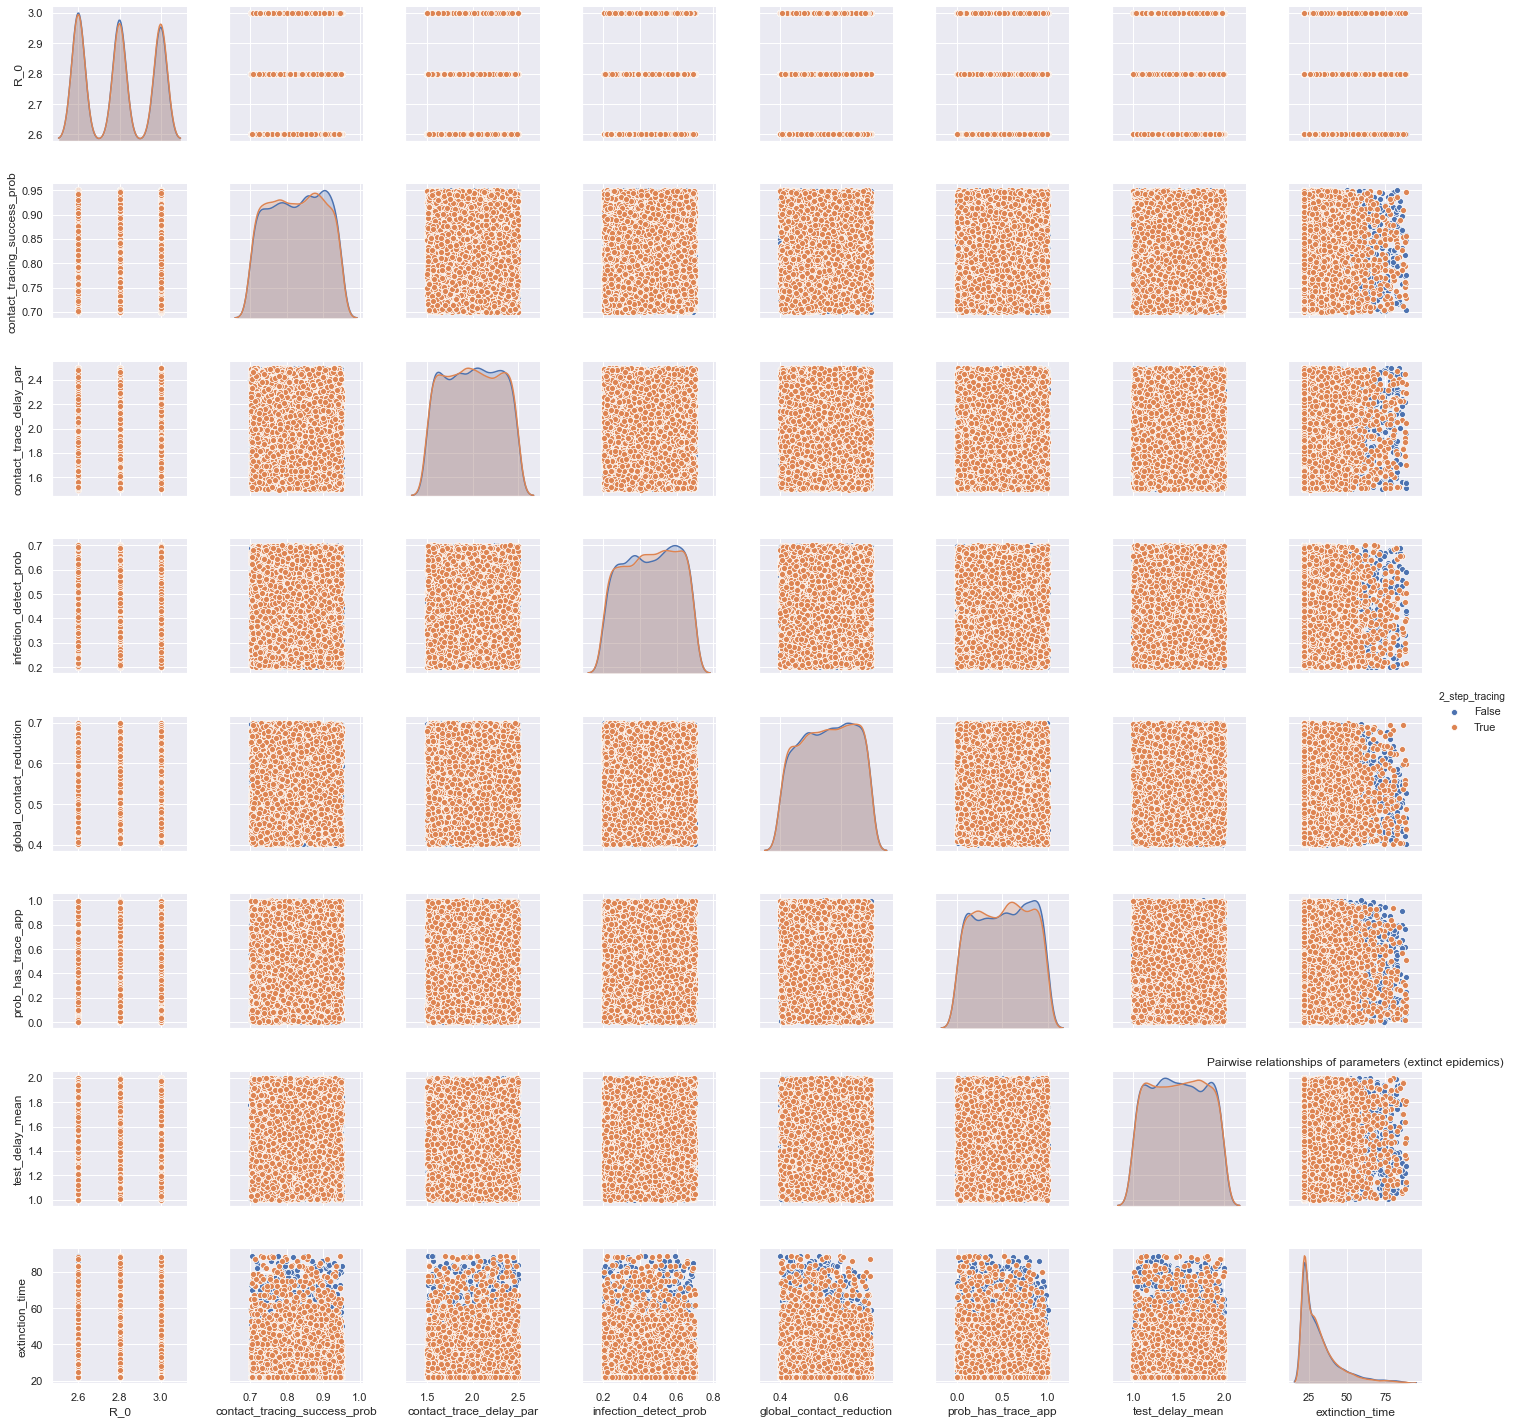

In [132]:
var_names = [
    "R_0",
    "contact_tracing_success_prob",
    "contact_trace_delay_par",
    "infection_detect_prob",
    "global_contact_reduction",
    "2_step_tracing",
    "prob_has_trace_app",
    "test_delay_mean",
    "extinction_time",
    ]

plot_names = [
    "R_0",
    "contact_tracing_success_prob",
    "contact_trace_delay_par",
    "infection_detect_prob",
    "global_contact_reduction",
    "prob_has_trace_app",
    "test_delay_mean",
    "extinction_time"
    ]
#two_step_not_extinct = epidemics_not_extinct[epidemics_not_extinct["2_step_tracing"] == True]
pair = sns.pairplot(epidemics_extinct[var_names], vars = plot_names, hue = "2_step_tracing")
plt.title("Pairwise relationships of parameters (extinct epidemics)")

                            OLS Regression Results                            
Dep. Variable:        extinction_time   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     42.91
Date:                Sun, 26 Apr 2020   Prob (F-statistic):           1.33e-51
Time:                        16:29:35   Log-Likelihood:                -24202.
No. Observations:                6135   AIC:                         4.842e+04
Df Residuals:                    6128   BIC:                         4.846e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

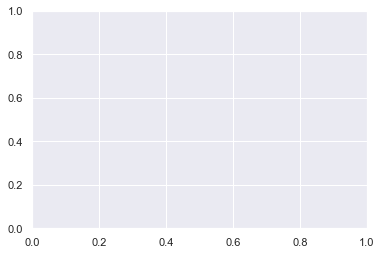

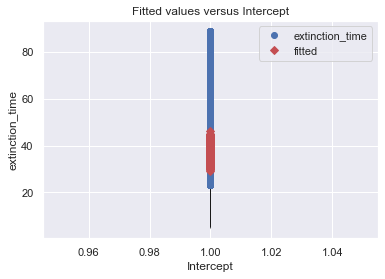

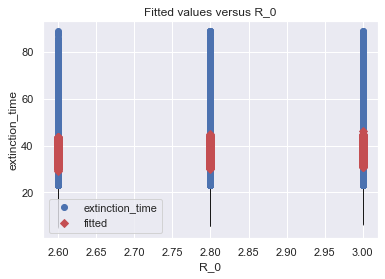

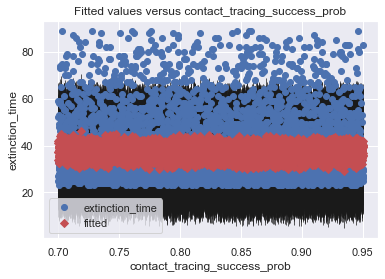

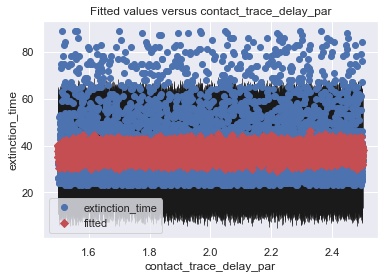

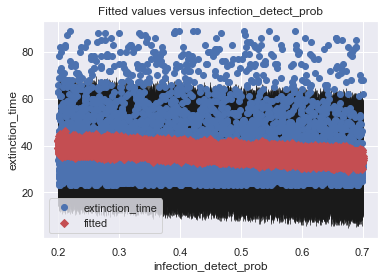

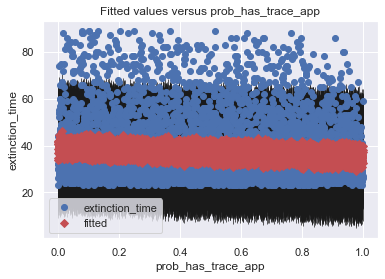

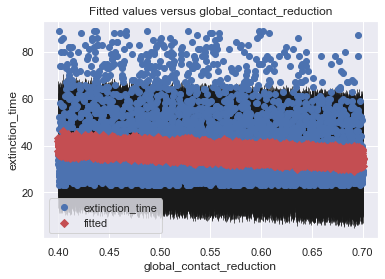

In [133]:
y, X = dmatrices('extinction_time ~ R_0 + contact_tracing_success_prob + contact_trace_delay_par + infection_detect_prob + prob_has_trace_app + global_contact_reduction + test_delay_mean', 
                 data = epidemics_extinct.loc[epidemics_extinct["extinction_time"] > 22], return_type='dataframe')
model = sma.OLS(y, X)
res = model.fit()
print(res.summary())
fig, ax = plt.subplots()
for i in range(7):

    fig = sm.graphics.regressionplots.plot_fit(res, i)

Text(0.5, 1.0, 'Extinction Times of Epidemcis (at least 1 transmission)')

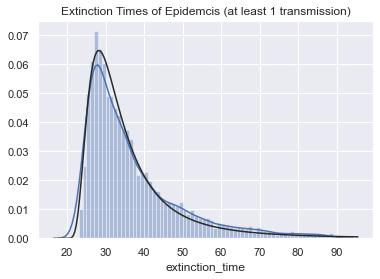

In [49]:
import scipy.stats as ss
sns.distplot(epidemics_extinct["extinction_time"].loc[epidemics_extinct["extinction_time"] > 22], bins = range(22, 90), fit = ss.genextreme)
plt.title("Extinction Times of Epidemcis (at least 1 transmission)")